# Machine Learning-based Run-Time Anomaly Detection for Software Systems

## Initial Setup

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torch==2.0.0 pandas sklearn numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=5a997e5aafc035cb52d02b093831d98d03d483dca3412557aa4bd5d80d4f433e
  Stored in directory: /root/.cache/pip/wheels/d5/b2/a9/590d15767d34955f20a9a033e8db973b79cb5672d95790c0a9
Successfully built sklearn


In [3]:
import time
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from multiprocessing import cpu_count
import gc
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DATA_CONFIG = {
    "RANDOM_STATE": 42,
    "USING_COLAB": True,
    "TEST_SET_SIZE": 0.1,
    "TIME_COLUMN": "timestamp",
    "TARGET_COLUMN": "isAnomaly",
    "TARGET_CLASS_NAMES": ["Anomaly", "No Anomaly"],
    "CREATE_PLOTS": True,
    "REMOVE_CORRELATED_FEATURES": True,
    "REMOVE_CONSTANT_FEATURES": True,
    "SEQUENCE_SIZE": 30,
    "BATCH_SIZE": 128
}

In [5]:
def scale_dataset(df: pd.DataFrame, df_scale_exclude_names, scaler):
    
    df_scale_exclude = df[df_scale_exclude_names]
    df_scale_include = df.drop(df_scale_exclude_names, axis=1)
    df_scale_include_names = df_scale_include.columns
    df_scale_include = scaler.fit_transform(df_scale_include)
    df_scale_include = pd.DataFrame(data=df_scale_include, columns=df_scale_include_names)
    df_scale_include = df_scale_include.reset_index(drop=True)
    df_scale_exclude = df_scale_exclude.reset_index(drop=True)
    scaled_df = pd.concat([df_scale_include, df_scale_exclude], axis=1)
    return scaled_df


def drop_constant_features(df: pd.DataFrame, feature_columns, features_only=True):
    
    if not features_only:
        excluded_columns = [column for column in data.columns if column not in feature_columns]
        excluded_columns = df[excluded_columns]
        df = df[feature_columns]

    print(f"Original number of features: {df.shape[1]}")
    drop_columns = [column for column in df.columns if df[column].nunique() == 1]
    df = df.drop(columns=drop_columns)
    print(f"Remaining number of features: {df.shape[1]}")

    if not features_only:
        df = pd.concat([df, excluded_columns], axis=1)
    
    return df, drop_columns


def plot_correlated_features(corr_matrix):

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', yticklabels=False, xticklabels=False)

    filepath = "/content/drive/MyDrive/" if DATA_CONFIG["USING_COLAB"] else "figures/"
    plt.savefig(f"{filepath}correlation_heatmap.pdf", bbox_inches="tight")
    plt.show()

def drop_correlated_features(df: pd.DataFrame, feature_columns, features_only=True, plot=False, threshold: float = 0.95):
  
    if not features_only:
        excluded_columns = [column for column in data.columns if column not in feature_columns]
        excluded_columns = df[excluded_columns]
        df = df[feature_columns]

    print(f"Original number of features: {df.shape[1]}")
    corr_matrix = df.corr()

    if plot:
        plot_correlated_features(corr_matrix)

    corr_matrix = corr_matrix.abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_columns = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    df = df.drop(columns=drop_columns)
    print(f"Remaining number of features: {df.shape[1]}")
    
    if not features_only:
        df = pd.concat([df, excluded_columns], axis=1)
    
    return df, drop_columns


def one_hot_encoding(df: pd.DataFrame, column_name: str):
    ohe = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, ohe], axis=1)
    df = df.drop(columns=column_name)
    return df


def x_y_split(df: pd.DataFrame, target_column: str):
    y = df[target_column]
    X = df.drop(columns=target_column)
    return X, y


def plot_target_col(data: pd.Series, max_y: int, y_tick_interval: int, target_class_names,
                    pdf_filename: str):
    blue = "#0D0887"
    yellow = "#FCD025"

    fig, ax = plt.subplots(figsize=(5 / 3 + 0.25, 5))

    bar_width = 0.25
    # set heights of bars
    minority_class_bar = [data.value_counts()[1]]
    majority_class_bar = [data.value_counts()[0]]

    # Set position of bar on X axis
    r1 = np.arange(len(minority_class_bar))
    r2 = [x + bar_width for x in r1]

    # Make the plot
    plt.bar(r1, minority_class_bar, color=blue, width=bar_width, edgecolor='white', label='Failure')
    plt.bar(r2, majority_class_bar, color=yellow, width=bar_width, edgecolor='white', label='No Failure')

    y_tick_positions = [i * y_tick_interval for i in range(0, max_y) if i * y_tick_interval <= max_y]
    ax.yaxis.set_ticks(y_tick_positions)
    ax.yaxis.set_ticklabels(y_tick_positions, size=16, fontweight=100)
    ax.yaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)

    ax.set_ylim((0, max_y))

    # Set whether axis ticks and gridlines are above or below most artists.
    ax.set_axisbelow(True)
    ax.grid(axis="y", color="#A8BAC4", lw=1.2)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_lw(1.5)
    # This capstyle determines the lines don't go beyond the limit we specified
    # see: https://matplotlib.org/stable/api/_enums_api.html?highlight=capstyle#matplotlib._enums.CapStyle
    ax.spines["left"].set_capstyle("butt")

    # Add xticks on the middle of the group bars
    plt.xlabel('Variable', fontweight='bold')
    plt.xticks([r + bar_width / 2 for r in range(len(minority_class_bar))], ['Categories'])

    # Create legend & Show graphic
    fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.1)

    plt.legend(target_class_names, bbox_to_anchor=([1.075, 1.2, 0, 0]), ncol=1, frameon=False, fontsize=12.5)
    fig.set_facecolor("white")

    filepath = "/content/drive/MyDrive/" if DATA_CONFIG["USING_COLAB"] else "figures/"
    plt.savefig(f"{filepath}{pdf_filename}.pdf", bbox_inches="tight")
    plt.show()

# Create sequences
def create_sequences(array, seq_length, target=False):
    i = 0
    while i < len(array) - seq_length:
        if target:
            yield array[i + seq_length - 1]
        else:
            yield array[i:i + seq_length]
        i += 1

        
def transform_sequences(array, seq_length, target=False):
    array = list(create_sequences(array, seq_length, target))
    array = np.array([value for value in array])
    return array

In [6]:
data = pd.read_csv("/content/drive/MyDrive/data.csv", engine="pyarrow")

DATA_CONFIG["FEATURE_COLUMNS"] = [feature for feature in data.columns if feature not in [DATA_CONFIG['TARGET_COLUMN'], DATA_CONFIG["TIME_COLUMN"]]]

In [7]:
data.shape

(188068, 235)

In [8]:
data.describe()

,"Prepared statement cache hit rate : ((MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))","Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))","Active connections : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","Available db connection activity : (d/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).NumAvailable))","Active connections : (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","DB connection started : (incld/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ConnectionsTotalCount))",Heap usage activity : (d/dx (MXBean(java.lang:type=Memory).HeapMemoryUsage.used)),"Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Stuck threads : (MXBean(com.bea:Name=ThreadPoolRuntime,Type=ThreadPoolRuntime).StuckThreadCount)","Reserve request activity : (incld/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ReserveRequestCount))",...,"Available db connection activity : (d/dx (MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source10,Type=JDBCConnectionPoolRuntime).NumAvailable))","Rel. unavailable connections : ((MXBean(com.bea:Name=source04,Type=JDBCDataSourceRuntime).NumUnavailable / MXBean(com.bea:Name=source04,Type=JDBCDataSourceRuntime).CurrCapacity))","Failed wait for connection : (incld/dx (MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).WaitingForConnectionFailureTotal))","Rel. unavailable connections : ((MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).NumUnavailable / MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).CurrCapacity))","Stuck threads : (MXBean(com.bea:ApplicationRuntime=source05,Name=default,Type=WorkManagerRuntime).StuckThreadCount)",Process CPU : (\Process(java)\CPU),"Successful wait for connection : (incld/dx (MXBean(com.bea:Name=source03,Type=JDBCDataSourceRuntime).WaitingForConnectionSuccessTotal))","Failed wait for connection : (incld/dx (MXBean(com.bea:Name=source03,Type=JDBCDataSourceRuntime).WaitingForConnectionFailureTotal))","Connection delay : (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ConnectionDelayTime)"
count,188068.000000,188068.000000,188068.0,188068.000000,188068.000000,188068.000000,1.880680e+05,188068.000000,188068.000000,188068.0,...,188068.000000,188068.0,188068.000000,188068.0,188068.000000,188068.0,188068.000000,188068.0,188068.0,188068.00000
mean,1.027576,0.701453,0.0,-0.000004,0.010129,0.000005,1.380974e+05,76.764394,0.181716,0.0,...,0.000000,0.0,0.000548,0.0,0.999787,0.0,46.367412,0.0,0.0,81.81940
std,0.229330,0.333852,0.0,0.004067,0.100134,0.002306,6.684241e+08,155.551443,0.433309,0.0,...,0.006522,0.0,0.023396,0.0,0.014582,0.0,112.458956,0.0,0.0,14.22921
min,0.005708,0.053711,0.0,-1.000000,0.000000,0.000000,-9.546473e+09,0.000000,0.000000,0.0,...,-1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,49.00000
25%,1.000000,0.386719,0.0,0.000000,0.000000,0.000000,-6.479014e+06,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.0,81.00000
50%,1.000000,0.941406,0.0,0.000000,0.000000,0.000000,3.727045e+07,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.0,82.00000
75%,1.000000,0.970052,0.0,0.000000,0.000000,0.000000,6.267492e+07,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,1.000000,0.0,39.000000,0.0,0.0,86.00000
max,1.806157,0.980469,0.0,1.000000,1.000000,1.000000,4.953991e+09,509.000000,3.000000,0.0,...,1.000000,0.0,1.000000,0.0,1.000000,0.0,1588.000000,0.0,0.0,122.00000


## Preprocessing

### Feature selection

First we remove this artificial column that says whether in a given measurement there was no data collection due to a system error such as an outage or node restart.

In [9]:
data = data.drop(columns="No data", axis=1)
DATA_CONFIG["FEATURE_COLUMNS"] = [feature for feature in data.columns if feature not in [DATA_CONFIG['TARGET_COLUMN'], DATA_CONFIG['TIME_COLUMN']]]

### Encoding

The target variable is still represented via booleans, to work with it we need to encode it.

In [10]:
le = LabelEncoder()
print(f'Original target values: {data[DATA_CONFIG["TARGET_COLUMN"]].unique()}')
data[DATA_CONFIG["TARGET_COLUMN"]] = le.fit_transform(data[DATA_CONFIG["TARGET_COLUMN"]])
print(f'Encoded target values: {data[DATA_CONFIG["TARGET_COLUMN"]].unique()}')

Original target values: [False  True]
Encoded target values: [0 1]


The *host* column and the *process* column are categorical, that's why we transform them via one-hot encoding.

In [11]:
try:
    data = one_hot_encoding(data, "process")
    data = one_hot_encoding(data, "host")
    DATA_CONFIG["FEATURE_COLUMNS"] = [feature for feature in data.columns if feature not in [DATA_CONFIG['TARGET_COLUMN'], DATA_CONFIG['TIME_COLUMN']]]

except KeyError:
    print("Already encoded categorical features")

Next we need to transform the date string into a representation the models can handle.
That's why we map the string representation to the UNIX timestamp format represented by integers.

### Dealing with time

In [12]:
data["timestamp"] = pd.to_datetime(data["timestamp"]).map(pd.Timestamp.timestamp).astype(int)

To work with sklearn's TimeSeriesSplit, we need to replace the index with the time dimension and sort it by this value.

In [13]:
try:
    data.set_index(DATA_CONFIG["TIME_COLUMN"], inplace=True)
    data.sort_values(by=DATA_CONFIG["TIME_COLUMN"], inplace=True)

except KeyError:
    print(f"Already set index to {DATA_CONFIG['TIME_COLUMN']}")

### Holdout validation split

To verify our models, we split the data into three partitions of size 80% - 10% - 10% for training, validation and testing.

In [14]:
split_index = int(data.shape[0] * (1 - DATA_CONFIG["TEST_SET_SIZE"]))
train_valid_set = data.iloc[:split_index, :]
test_set = data.iloc[split_index:, :]

In [15]:
tss = TimeSeriesSplit(n_splits=5)

In [16]:
X, y = x_y_split(train_valid_set, target_column=DATA_CONFIG["TARGET_COLUMN"])

In [17]:
X_test, y_test = x_y_split(test_set, target_column=DATA_CONFIG["TARGET_COLUMN"])

In [18]:
for train_index, test_index in tss.split(X):
    X_train, X_valid = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

# checking whether split was correct
print(f"Training set index:\n{X_train.index}\n")
print(f"Test set index:\n{X_test.index}\n")

Training set index:
Int64Index([1417219200, 1417219260, 1417219320, 1417219380, 1417219440,
            1417219500, 1417219560, 1417219620, 1417219680, 1417219740,
            ...
            1440999900, 1440999960, 1441000020, 1441000080, 1441000140,
            1441000200, 1441000260, 1441000320, 1441000380, 1441000440],
           dtype='int64', name='timestamp', length=141051)

Test set index:
Int64Index([1442695560, 1442695620, 1442695680, 1442695740, 1442695800,
            1442695860, 1442695920, 1442695980, 1442696040, 1442696100,
            ...
            1443829860, 1443829920, 1443829980, 1443830040, 1443830100,
            1443830160, 1443830220, 1443830280, 1443830340, 1443830400],
           dtype='int64', name='timestamp', length=18807)


### Correlation and constant values

Columns containing correlated values tend to worsen model performance, therefore they can be removed to reduce complexity and improve resource utilization.


Original number of features: 235


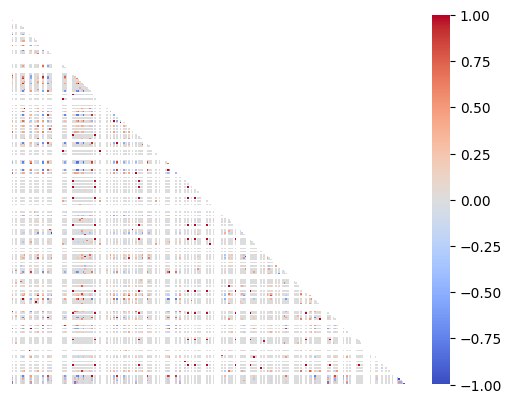

Remaining number of features: 197


In [19]:
if DATA_CONFIG["REMOVE_CORRELATED_FEATURES"]:
    X_train, correlated_columns = drop_correlated_features(X_train, feature_columns=DATA_CONFIG["FEATURE_COLUMNS"], threshold=0.95, plot=DATA_CONFIG["CREATE_PLOTS"])
    DATA_CONFIG["FEATURE_COLUMNS"] = [feature for feature in X_train.columns]
    X_valid = X_valid.drop(columns=correlated_columns)
    X_test = X_test.drop(columns=correlated_columns)

Columns containing constant values, i.e. columns that contain just one unique value don't add anything to the model, therefore they can be removed to reduce complexity and improve resource utilization.


In [20]:
if DATA_CONFIG["REMOVE_CONSTANT_FEATURES"]:
    X_train, constant_columns = drop_constant_features(X_train, feature_columns=DATA_CONFIG["FEATURE_COLUMNS"])
    DATA_CONFIG["FEATURE_COLUMNS"] = [feature for feature in X_train.columns]
    X_valid = X_valid.drop(columns=constant_columns)
    X_test = X_test.drop(columns=constant_columns)


Original number of features: 197
Remaining number of features: 87


### Undersampling

In [21]:
y_train.value_counts(normalize=True)

0    0.835868
1    0.164132
Name: isAnomaly, dtype: float64

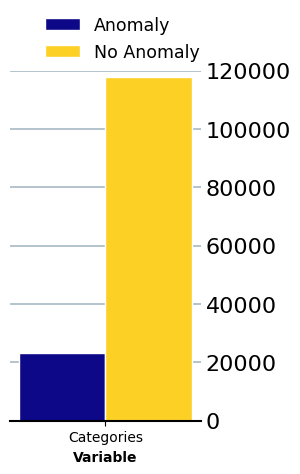

In [22]:
if DATA_CONFIG["CREATE_PLOTS"]:
    plot_target_col(data=y_train, max_y=120000, y_tick_interval=20000,
                    target_class_names=DATA_CONFIG["TARGET_CLASS_NAMES"], pdf_filename="eda_categories")

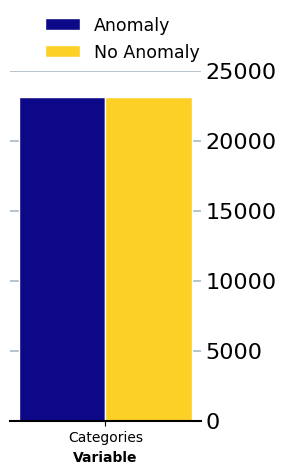

In [23]:
# undersampling
rus = RandomUnderSampler(random_state=DATA_CONFIG["RANDOM_STATE"])
X_train, y_train = rus.fit_resample(X_train, y_train)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

if DATA_CONFIG["CREATE_PLOTS"]:
    plot_target_col(data=y_train, max_y=25000, y_tick_interval=5000,
                    target_class_names=DATA_CONFIG["TARGET_CLASS_NAMES"], pdf_filename="eda_categories_balanced")

### Scaling

In [24]:
exclude_from_scaling = np.array([feature for feature in X_train.columns if feature.startswith(("process", "host"))])
print(f"Features not included in scaling: {exclude_from_scaling}")
    
mms_train = StandardScaler()
X_train = scale_dataset(X_train, exclude_from_scaling, mms_train)

mms_valid = StandardScaler()
X_valid = scale_dataset(X_valid, exclude_from_scaling, mms_valid)

mms_test = StandardScaler()
X_test = scale_dataset(X_test, exclude_from_scaling, mms_test)

Features not included in scaling: ['process_wls1' 'host_lphost06' 'host_lphost14' 'host_lphost15']


Serialize the test data to load it at a later point again.

In [25]:
#serialized_test_data = pd.concat([X_test, y_test], axis=1)
#torch.save(serialized_test_data, "/content/drive/MyDrive/test_set.pth")

In [26]:
available_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {'cuda' if torch.cuda.is_available() else 'cpu'} for model training")

Using cuda for model training


## LSTM

### LSTM data preparation

To make our dataset work with LSTM, we need to add another dimension to it by sequencing the dataset. Since one measurement is taken every minute, we created a sequence that contains a one hour window.
Applying *np.array()* on the sequence helps speeding up the creation of tensors in the next step.

We then convert our sequenced dataset into PyTorch tensors.

In [83]:
X_train_seq = transform_sequences(X_train.values, DATA_CONFIG["SEQUENCE_SIZE"])
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(available_device)
print(f"X_train size: {X_train_tensor.size()}")

y_train_seq = transform_sequences(y_train.values, DATA_CONFIG["SEQUENCE_SIZE"], target=True)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).to(available_device)
print(f"y_train size: {y_train_tensor.size()}")

X_valid_seq = transform_sequences(X_valid.values, DATA_CONFIG["SEQUENCE_SIZE"])
X_valid_tensor = torch.tensor(X_valid_seq, dtype=torch.float32).to(available_device)
print(f"X_valid size: {X_valid_tensor.size()}")

y_valid_seq = transform_sequences(y_valid.values, DATA_CONFIG["SEQUENCE_SIZE"], target=True)
y_valid_tensor = torch.tensor(y_valid_seq, dtype=torch.float32).to(available_device)
print(f"y_valid size: {y_valid_tensor.size()}")

X_test_seq = transform_sequences(X_test.values, DATA_CONFIG["SEQUENCE_SIZE"])
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(available_device)
print(f"X_test size: {X_test_tensor.size()}")

y_test_seq = transform_sequences(y_test.values, DATA_CONFIG["SEQUENCE_SIZE"], target=True)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(available_device)
print(f"y_test size: {y_test_tensor.size()}")

X_train size: torch.Size([46272, 30, 87])
y_train size: torch.Size([46272])
X_valid size: torch.Size([28180, 30, 87])
y_valid size: torch.Size([28180])
X_test size: torch.Size([18777, 30, 87])
y_test size: torch.Size([18777])


For the final step, we create batches of 128. In case CUDA is not available, we also optimized the CPU-utilizing version.

In [96]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

if torch.cuda.is_available():
    train_dataloader = DataLoader(train_dataset, batch_size=DATA_CONFIG["BATCH_SIZE"], shuffle=False)
    valid_dataloader = DataLoader(valid_dataset, batch_size=DATA_CONFIG["BATCH_SIZE"], shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=DATA_CONFIG["BATCH_SIZE"], shuffle=False)
else:
    # 2 is apparently the recommended number for colab
    NUM_WORKERS = 2
    train_dataloader = DataLoader(train_dataset, batch_size=DATA_CONFIG["BATCH_SIZE"], shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=DATA_CONFIG["BATCH_SIZE"], shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=DATA_CONFIG["BATCH_SIZE"], shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


In [97]:
torch.save(test_dataloader, "/content/drive/MyDrive/test_set.pth")

### Model declaration

In [85]:
# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_reguralization):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_reguralization)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(available_device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(available_device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


def train_lstm(model, optimizer, num_epochs, lr, train_data):
    training_start = time.time()
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_data):
            inputs = inputs.to(available_device)
            labels = labels.long().to(available_device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    training_duration = time.time() - training_start
    print(f'Training took {training_duration:.2f} seconds')


def evaluate_model(model, test_data: DataLoader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_dataloader:
            labels = labels.long()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy: {100 * correct / total:.2f}%')


def train_evaluate_lstm(model, optimizer, num_epochs, lr, train_data: DataLoader, test_data: DataLoader):
    train_lstm(model=model, optimizer=optimizer, num_epochs=num_epochs, lr=lr, train_data=train_data)
    evaluate_model(model=model, test_data=test_data)

### Base line model

Using an LSTM with 2 layers with a hidden size of 200 as the baseline model, due to it's usage in the original paper by Huch et al. 

In [ ]:
model_config = {
    "input_size": X_train_tensor.size(2),
    "hidden_size": 200,
    "num_layers": 2,
    "num_outputs": 2,
    "learning_rate": 0.0025,
    "num_epochs": 10,
    "dropout_rate": 0,
    "weight_decay": 0
}

model1 = LSTMClassifier(model_config["input_size"], model_config["hidden_size"], model_config["num_layers"], model_config["num_outputs"], model_config["dropout_rate"]).to(available_device)
model_config["optimizer"] = torch.optim.RMSprop(model1.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"])
train_evaluate_lstm(model=model1, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], train_data=train_dataloader, test_data=valid_dataloader)

Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 26.89 seconds
Accuracy: 74.22%


### Reduce to one layer

Next, we're trying to simplify the architecture by just using one layer of LSTM cells to reduce training time while getting similar model performance, while other parameters stay the same.

In [ ]:
model_config = {
    "input_size": X_train_tensor.size(2),
    "hidden_size": 200,
    "num_layers": 1,
    "num_outputs": 2,
    "learning_rate": 0.0025,
    "num_epochs": 10,
    "dropout_rate": 0,
    "weight_decay": 0
}

model2 = LSTMClassifier(model_config["input_size"], model_config["hidden_size"], model_config["num_layers"], model_config["num_outputs"], model_config["dropout_rate"]).to(available_device)
model_config["optimizer"] = torch.optim.RMSprop(model2.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"])
train_evaluate_lstm(model=model2, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], train_data=train_dataloader, test_data=valid_dataloader)

Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 14.58 seconds
Accuracy: 72.91%


### Learning rate

In [ ]:
model_config = {
    "input_size": X_train_tensor.size(2),
    "num_layers": 1,
    "num_outputs": 2,
    "hidden_size": 200,
    "num_epochs": 10,
    "dropout_rate": 0,
    "weight_decay": 0
}

learning_rate_variations = [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005]

for learning_rate in learning_rate_variations:

    model_config["learning_rate"] = learning_rate
    print(f"\nTrying learning_rate={model_config['learning_rate']}")
    
    learning_rate_variations_lstm = LSTMClassifier(model_config["input_size"], model_config["hidden_size"], model_config["num_layers"], model_config["num_outputs"], model_config["dropout_rate"]).to(available_device)

    model_config["optimizer"] = torch.optim.RMSprop(learning_rate_variations_lstm.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"])

    train_evaluate_lstm(model=learning_rate_variations_lstm, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], train_data=train_dataloader, test_data=valid_dataloader)


Trying learning_rate=0.001
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 13.36 seconds
Accuracy: 74.81%

Trying learning_rate=0.0015
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 15.49 seconds
Accuracy: 72.83%

Trying learning_rate=0.002
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 25.83 seconds
Accuracy: 73.69%

Trying learning_rate=0.0025
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 22.03 seconds
Accuracy: 62.21%

Trying learning_rate=0.003
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 19.58 seconds
Accuracy: 76.20%

Trying learning_rate=0.0035
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 22.68 seconds
Accuracy: 74.78%

Trying learning_rate=0.004
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 20.14 seconds
Accuracy: 77.26%

Trying learning_rate=0.0045
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 21.

### Hidden_size

Next, we try out the effect of model size on model performance by trying different combinations.

In [ ]:
model_config = {
    "input_size": X_train_tensor.size(2),
    "num_layers": 1,
    "num_outputs": 2,
    "learning_rate": 0.0025,
    "num_epochs": 10,
    "dropout_rate": 0,
    "weight_decay": 0
}

hidden_size_variations = [50, 100, 150, 200]

for hidden_size in hidden_size_variations:

    model_config["hidden_size"] = hidden_size
    print(f"\nTrying hidden_size={model_config['hidden_size']}")
    
    hidden_size_variations_model = LSTMClassifier(model_config["input_size"], model_config["hidden_size"], model_config["num_layers"], model_config["num_outputs"], model_config["dropout_rate"]).to(available_device)

    model_config["optimizer"] = torch.optim.RMSprop(hidden_size_variations_model.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"])

    train_evaluate_lstm(model=hidden_size_variations_model, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], train_data=train_dataloader, test_data=valid_dataloader)


Trying hidden_size=50
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 12.22 seconds
Accuracy: 77.43%

Trying hidden_size=100
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 11.97 seconds
Accuracy: 75.92%

Trying hidden_size=150
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 20.85 seconds
Accuracy: 78.10%

Trying hidden_size=200
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 15.99 seconds
Accuracy: 75.24%


We see that the model with a `hidden_size` of 100 performs best for one layer.

### Hidden_size with 2 layers

Let's introduce a second layer so that we can also experiment with a dropout rate at a later point. A second layer is necessary for dropout since PyTorch's LSTM implementation adds dropout for every layer except the nth layer, so with `num_layers=1`, dropout wouldn't be applied. We then try out the same combinations of hidden_size as in the previous experiment to find a good 'hidden_size'.

In [ ]:
model_config = {
    "input_size": X_train_tensor.size(2),
    "num_layers": 2,
    "num_outputs": 2,
    "learning_rate": 0.0025,
    "num_epochs": 10,
    "dropout_rate": 0,
    "weight_decay": 0
}

hidden_size_variations = [50, 100, 150, 200]

for hidden_size in hidden_size_variations:

    model_config["hidden_size"] = hidden_size
    print(f"\nTrying hidden_size={model_config['hidden_size']}")
    
    hidden_size_variations_model = LSTMClassifier(model_config["input_size"], model_config["hidden_size"], model_config["num_layers"], model_config["num_outputs"], model_config["dropout_rate"]).to(available_device)

    model_config["optimizer"] = torch.optim.RMSprop(hidden_size_variations_model.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"])

    train_evaluate_lstm(model=hidden_size_variations_model, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], train_data=train_dataloader, test_data=valid_dataloader)


Trying hidden_size=50
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 10.87 seconds
Accuracy: 74.04%

Trying hidden_size=100
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 10.59 seconds
Accuracy: 78.44%

Trying hidden_size=150
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 25.47 seconds
Accuracy: 66.98%

Trying hidden_size=200
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 19.76 seconds
Accuracy: 81.47%


### Dropout rate

In [ ]:
model_config = {
    "input_size": X_train_tensor.size(2),
    "num_layers": 2,
    "num_outputs": 2,
    "hidden_size": 100,
    "learning_rate": 0.0025,
    "num_epochs": 10,
    "weight_decay": 0
}

dropout_rate_variations = [0.2, 0.4]

for dropout_rate in dropout_rate_variations:

    model_config["dropout_rate"] = dropout_rate
    print(f"\nTrying dropout_rate={model_config['dropout_rate']}")
    
    dropout_rate_variations_model = LSTMClassifier(model_config["input_size"], model_config["hidden_size"], model_config["num_layers"], model_config["num_outputs"], model_config["dropout_rate"]).to(available_device)

    model_config["optimizer"] = torch.optim.RMSprop(dropout_rate_variations_model.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"])

    train_evaluate_lstm(model=dropout_rate_variations_model, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], train_data=train_dataloader, test_data=valid_dataloader)


Trying dropout_rate=0.2
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 12.00 seconds
Accuracy: 76.21%

Trying dropout_rate=0.4
Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 10.60 seconds
Accuracy: 58.41%


### Weight decay

In [ ]:
model_config = {
    "input_size": X_train_tensor.size(2),
    "hidden_size": 100,
    "num_layers": 2,
    "num_outputs": 2,
    "learning_rate": 0.0025,
    "num_epochs": 10,
    "dropout_rate": 0.4,
    "weight_decay": 0.0001
}


model3 = LSTMClassifier(model_config["input_size"], model_config["hidden_size"], model_config["num_layers"], model_config["num_outputs"], model_config["dropout_rate"]).to(available_device)
model_config["optimizer"] = torch.optim.RMSprop(model3.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"])
train_evaluate_lstm(model=model3, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], train_data=train_dataloader, test_data=valid_dataloader)

Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 16.51 seconds
Accuracy: 58.92%


### Best LSTM model

In [101]:
model_config = {
    "input_size": X_train_tensor.size(2),
    "hidden_size": 100,
    "num_layers": 2,
    "num_outputs": 2,
    "learning_rate": 0.0025,
    "num_epochs": 10,
    "dropout_rate": 0.4,
    "weight_decay": 0
}

best_lstm = LSTMClassifier(model_config["input_size"], model_config["hidden_size"], model_config["num_layers"], model_config["num_outputs"], model_config["dropout_rate"]).to(available_device)
model_config["optimizer"] = torch.optim.RMSprop(best_lstm.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"])
train_evaluate_lstm(model=best_lstm, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], train_data=train_dataloader, test_data=valid_dataloader)

Epoch [5/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training took 15.13 seconds
Accuracy: 75.81%


In [ ]:
#torch.save(best_lstm, "/content/drive/MyDrive/lstm.pth")

## MLP

### MLP data preparation



In [27]:
X_train_mlp_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(available_device)
y_train_mlp_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(available_device)

X_valid_mlp_tensor = torch.tensor(X_valid.values, dtype=torch.float32).to(available_device)
y_valid_mlp_tensor = torch.tensor(y_valid.values, dtype=torch.float32).to(available_device)

X_test_mlp_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(available_device)
y_test_mlp_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(available_device)

In [103]:
torch.save(X_test_mlp_tensor, "/content/drive/MyDrive/X_test_mlp.pth")
torch.save(y_test_mlp_tensor, "/content/drive/MyDrive/y_test_mlp.pth")

### Model declaration

In [47]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.fc3(out)
        out = self.tanh(out)
        out = self.fc4(out)
        out = self.softmax(out)
        return out


def train_mlp(model, optimizer, num_epochs: int, lr, X_train, y_train, window_mechanism: str, window_size: int, step_size: int):

    implemented_window_mechanisms = ["sliding", "increasing"]
    if window_mechanism not in implemented_window_mechanisms:
        raise ValueError(f"{window_mechanism} not supported; please specify one of the following: {implemented_window_mechanisms}")
    
    if window_size <= 0:
        raise ValueError(f"Please use a window_size > 0")
    if step_size <= 0:
        raise ValueError(f"Please use a step_size > 0")

    criterion = nn.CrossEntropyLoss()
    y_train = y_train.long()
    training_start = time.time()

    for epoch in range(num_epochs):

        if window_mechanism == "sliding":
            num_windows = ((len(X_train) - window_size) // step_size) + 2
            remainder = ((len(X_train) - window_size) % step_size)
            value_range = range(num_windows)
        elif window_mechanism == "increasing":
            value_range = range(0, len(X_train), step_size)
            
        for i in value_range:
            if window_mechanism == "sliding":
                window_start = i * step_size

                # differentation between full and incomplete windows at the end of the array
                if i < num_windows - 1:
                    window_end = i * step_size + window_size
                elif i == num_windows - 1 and remainder != 0:
                    window_end = i * step_size + remainder

            elif window_mechanism == "increasing":
                window_start = 0
                window_end = i + step_size

            X_train_windowed, y_train_windowed = create_window(X_train, y_train, window_start, window_end)

            loss = train_mlp_step(model, X_train_windowed, y_train_windowed, criterion, optimizer)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    training_duration = time.time() - training_start
    print(f'Training took {training_duration:.2f} seconds')


def create_window(X_train: torch.Tensor, y_train: torch.Tensor, start_index, end_index):
    X_train_windowed = X_train[start_index:end_index]
    y_train_windowed = y_train[start_index:end_index]

    return X_train_windowed, y_train_windowed

def train_mlp_step(model, X_train, y_train, criterion, optimizer):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


def evaluate_mlp(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        y_test = y_test.long()
        output = model(X_test)
        _, y_pred = torch.max(output.data, 1)
        total += y_test.size(0)
        correct += (y_pred == y_test).sum().item()

        print(f'Accuracy: {100 * correct / total:.2f}%')


def train_evaluate_mlp(model, optimizer, num_epochs, lr, X_train, y_train, window_mechanism, window_size, step_size, X_test, y_test):
    train_mlp(model=model, optimizer=optimizer, num_epochs=num_epochs, lr=lr, X_train=X_train, y_train=y_train, window_mechanism=window_mechanism, window_size=window_size, step_size=step_size)
    evaluate_mlp(model=model, X_test=X_test, y_test=y_test)

### Base line model

In [48]:
model_config = {
    "input_size": X_train_mlp_tensor.size(1),
    "hidden_size1": 100,
    "hidden_size2": 100,
    "hidden_size3": 100,
    "num_outputs": 2,
    "learning_rate": 0.0025,
    "window_mechanism": "sliding",
    "window_size": 30,
    "step_size": 30,
    "num_epochs": 10,
    "weight_decay": 0,
    "momentum": 0,
}

#### Tumbling window

In [49]:
model_config["window_mechanism"] = "sliding"
model_config["window_size"] = 30
model_config["step_size"] = 30

print(f"Using window_mechanism={model_config['window_mechanism']}")

t_mlp1 = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)

model_config["optimizer"] = torch.optim.SGD(t_mlp1.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])

train_evaluate_mlp(model=t_mlp1, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=sliding
Epoch [5/10], Loss: 0.3137
Epoch [10/10], Loss: 0.3134
Training took 18.79 seconds
Accuracy: 58.40%


#### Sliding window

In [50]:
model_config["window_mechanism"] = "sliding"
model_config["window_size"] = 30
model_config["step_size"] = 15

print(f"Using window_mechanism={model_config['window_mechanism']}")

s_mlp1 = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)

model_config["optimizer"] = torch.optim.SGD(s_mlp1.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])

train_evaluate_mlp(model=s_mlp1, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=sliding
Epoch [5/10], Loss: 0.3134
Epoch [10/10], Loss: 0.3133
Training took 35.33 seconds
Accuracy: 59.08%


#### Increasing window

In [51]:
model_config["window_mechanism"] = "increasing"
model_config["window_size"] = 30
model_config["step_size"] = 15

print(f"Using window_mechanism={model_config['window_mechanism']}")

i_mlp1 = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)

model_config["optimizer"] = torch.optim.SGD(i_mlp1.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])

train_evaluate_mlp(model=i_mlp1, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=increasing
Epoch [5/10], Loss: 0.3277
Epoch [10/10], Loss: 0.3245
Training took 79.02 seconds
Accuracy: 71.47%


### Learning rate

In [52]:
model_config = {
    "input_size": X_train_mlp_tensor.size(1),
    "hidden_size1": 100,
    "hidden_size2": 100,
    "hidden_size3": 100,
    "num_outputs": 2,
    "window_size": 30,
    "num_epochs": 10,
    "weight_decay": 0,
    "momentum": 0,
}

learning_rate_experiment = [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005]

#### Tumbling window

In [53]:
model_config["window_mechanism"] = "sliding"
model_config["window_size"] = 30
model_config["step_size"] = 30

print(f"Using window_mechanism={model_config['window_mechanism']}")

for lr in learning_rate_experiment:
    model_config["learning_rate"] = lr
    print(f"\nTrying learning_rate={model_config['learning_rate']}")
    
    mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
    model_config["optimizer"] = torch.optim.SGD(mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
    train_evaluate_mlp(model=mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=sliding

Trying learning_rate=0.001
Epoch [5/10], Loss: 0.3150
Epoch [10/10], Loss: 0.3137
Training took 17.88 seconds
Accuracy: 57.63%

Trying learning_rate=0.0015
Epoch [5/10], Loss: 0.3140
Epoch [10/10], Loss: 0.3135
Training took 18.52 seconds
Accuracy: 63.28%

Trying learning_rate=0.002
Epoch [5/10], Loss: 0.3140
Epoch [10/10], Loss: 0.3135
Training took 17.94 seconds
Accuracy: 69.50%

Trying learning_rate=0.0025
Epoch [5/10], Loss: 0.3136
Epoch [10/10], Loss: 0.3134
Training took 17.90 seconds
Accuracy: 63.33%

Trying learning_rate=0.003
Epoch [5/10], Loss: 0.3135
Epoch [10/10], Loss: 0.3133
Training took 18.33 seconds
Accuracy: 60.90%

Trying learning_rate=0.0035
Epoch [5/10], Loss: 0.3134
Epoch [10/10], Loss: 0.3133
Training took 17.67 seconds
Accuracy: 61.31%

Trying learning_rate=0.004
Epoch [5/10], Loss: 0.3134
Epoch [10/10], Loss: 0.3133
Training took 18.03 seconds
Accuracy: 61.23%

Trying learning_rate=0.0045
Epoch [5/10], Loss: 0.3134
Epoch [10/10],

#### Sliding window

In [54]:
model_config["window_mechanism"] = "sliding"
model_config["window_size"] = 30
model_config["step_size"] = 15

print(f"Using window_mechanism={model_config['window_mechanism']}")

for lr in learning_rate_experiment:
    model_config["learning_rate"] = lr
    print(f"\nTrying learning_rate={model_config['learning_rate']}")
    
    mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
    model_config["optimizer"] = torch.optim.SGD(mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
    train_evaluate_mlp(model=mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=sliding

Trying learning_rate=0.001
Epoch [5/10], Loss: 0.3140
Epoch [10/10], Loss: 0.3135
Training took 36.49 seconds
Accuracy: 55.67%

Trying learning_rate=0.0015
Epoch [5/10], Loss: 0.3136
Epoch [10/10], Loss: 0.3134
Training took 35.71 seconds
Accuracy: 56.19%

Trying learning_rate=0.002
Epoch [5/10], Loss: 0.3134
Epoch [10/10], Loss: 0.3133
Training took 35.71 seconds
Accuracy: 60.11%

Trying learning_rate=0.0025
Epoch [5/10], Loss: 0.3134
Epoch [10/10], Loss: 0.3133
Training took 36.45 seconds
Accuracy: 64.18%

Trying learning_rate=0.003
Epoch [5/10], Loss: 0.3134
Epoch [10/10], Loss: 0.3133
Training took 35.86 seconds
Accuracy: 62.70%

Trying learning_rate=0.0035
Epoch [5/10], Loss: 0.3133
Epoch [10/10], Loss: 0.3133
Training took 35.71 seconds
Accuracy: 61.86%

Trying learning_rate=0.004
Epoch [5/10], Loss: 0.3133
Epoch [10/10], Loss: 0.3133
Training took 35.97 seconds
Accuracy: 61.63%

Trying learning_rate=0.0045
Epoch [5/10], Loss: 0.3133
Epoch [10/10],

#### Increasing window

In [55]:
model_config["window_mechanism"] = "increasing"
model_config["window_size"] = 30
model_config["step_size"] = 30

print(f"Using window_mechanism={model_config['window_mechanism']}")

for lr in learning_rate_experiment:
    model_config["learning_rate"] = lr
    print(f"\nTrying learning_rate={model_config['learning_rate']}")
    
    mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
    model_config["optimizer"] = torch.optim.SGD(mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
    train_evaluate_mlp(model=mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=increasing

Trying learning_rate=0.001
Epoch [5/10], Loss: 0.3953
Epoch [10/10], Loss: 0.3382
Training took 30.81 seconds
Accuracy: 78.76%

Trying learning_rate=0.0015
Epoch [5/10], Loss: 0.3414
Epoch [10/10], Loss: 0.3298
Training took 29.87 seconds
Accuracy: 73.59%

Trying learning_rate=0.002
Epoch [5/10], Loss: 0.3349
Epoch [10/10], Loss: 0.3281
Training took 29.94 seconds
Accuracy: 73.93%

Trying learning_rate=0.0025
Epoch [5/10], Loss: 0.3310
Epoch [10/10], Loss: 0.3260
Training took 29.76 seconds
Accuracy: 75.01%

Trying learning_rate=0.003
Epoch [5/10], Loss: 0.3296
Epoch [10/10], Loss: 0.3257
Training took 29.77 seconds
Accuracy: 77.82%

Trying learning_rate=0.0035
Epoch [5/10], Loss: 0.3288
Epoch [10/10], Loss: 0.3255
Training took 29.90 seconds
Accuracy: 77.48%

Trying learning_rate=0.004
Epoch [5/10], Loss: 0.3270
Epoch [10/10], Loss: 0.3242
Training took 29.67 seconds
Accuracy: 75.22%

Trying learning_rate=0.0045
Epoch [5/10], Loss: 0.3267
Epoch [10/1

### Hidden size

In [ ]:
model_config = {
    "input_size": X_train_mlp_tensor.size(1),
    "hidden_size1": 100,
    "hidden_size2": 100,
    "hidden_size3": 100,
    "num_outputs": 2,
    "learning_rate": 0.003,
    "num_epochs": 10,
    "weight_decay": 0,
    "momentum": 0,
}

hidden_size_experiment = [50, 100]

#### Tumbling window

In [57]:
model_config["window_mechanism"] = "sliding"
model_config["window_size"] = 30
model_config["step_size"] = 30

print(f"Using window_mechanism={model_config['window_mechanism']}")


for hidden_size1 in hidden_size_experiment:
    for hidden_size2 in hidden_size_experiment:
        for hidden_size3 in hidden_size_experiment:
            model_config["hidden_size1"] = hidden_size1
            model_config["hidden_size2"] = hidden_size2
            model_config["hidden_size3"] = hidden_size3
            print(f"\nTrying hidden_size1={model_config['hidden_size1']}, hidden_size2={model_config['hidden_size2']}, hidden_size3={model_config['hidden_size3']}")

            mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
            model_config["optimizer"] = torch.optim.SGD(mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
            train_evaluate_mlp(model=mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=sliding

Trying hidden_size1=50, hidden_size2=50, hidden_size3=50
Epoch [5/10], Loss: 0.3138
Epoch [10/10], Loss: 0.3135
Training took 17.59 seconds
Accuracy: 61.97%

Trying hidden_size1=50, hidden_size2=50, hidden_size3=100
Epoch [5/10], Loss: 0.3136
Epoch [10/10], Loss: 0.3134
Training took 18.12 seconds
Accuracy: 59.09%

Trying hidden_size1=50, hidden_size2=100, hidden_size3=50
Epoch [5/10], Loss: 0.3136
Epoch [10/10], Loss: 0.3134
Training took 18.07 seconds
Accuracy: 64.46%

Trying hidden_size1=50, hidden_size2=100, hidden_size3=100
Epoch [5/10], Loss: 0.3135
Epoch [10/10], Loss: 0.3133
Training took 17.62 seconds
Accuracy: 61.40%

Trying hidden_size1=100, hidden_size2=50, hidden_size3=50
Epoch [5/10], Loss: 0.3138
Epoch [10/10], Loss: 0.3134
Training took 18.14 seconds
Accuracy: 61.08%

Trying hidden_size1=100, hidden_size2=50, hidden_size3=100
Epoch [5/10], Loss: 0.3137
Epoch [10/10], Loss: 0.3134
Training took 17.89 seconds
Accuracy: 61.66%

Trying hidden

#### Sliding window

In [58]:
model_config["window_mechanism"] = "sliding"
model_config["window_size"] = 30
model_config["step_size"] = 15

print(f"Using window_mechanism={model_config['window_mechanism']}")


for hidden_size1 in hidden_size_experiment:
    for hidden_size2 in hidden_size_experiment:
        for hidden_size3 in hidden_size_experiment:
            model_config["hidden_size1"] = hidden_size1
            model_config["hidden_size2"] = hidden_size2
            model_config["hidden_size3"] = hidden_size3
            print(f"\nTrying hidden_size1={model_config['hidden_size1']}, hidden_size2={model_config['hidden_size2']}, hidden_size3={model_config['hidden_size3']}")

            mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
            model_config["optimizer"] = torch.optim.SGD(mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
            train_evaluate_mlp(model=mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=sliding

Trying hidden_size1=50, hidden_size2=50, hidden_size3=50
Epoch [5/10], Loss: 0.3136
Epoch [10/10], Loss: 0.3134
Training took 35.62 seconds
Accuracy: 63.03%

Trying hidden_size1=50, hidden_size2=50, hidden_size3=100
Epoch [5/10], Loss: 0.3134
Epoch [10/10], Loss: 0.3133
Training took 36.23 seconds
Accuracy: 60.50%

Trying hidden_size1=50, hidden_size2=100, hidden_size3=50
Epoch [5/10], Loss: 0.3135
Epoch [10/10], Loss: 0.3133
Training took 35.62 seconds
Accuracy: 61.50%

Trying hidden_size1=50, hidden_size2=100, hidden_size3=100
Epoch [5/10], Loss: 0.3134
Epoch [10/10], Loss: 0.3133
Training took 35.80 seconds
Accuracy: 64.14%

Trying hidden_size1=100, hidden_size2=50, hidden_size3=50
Epoch [5/10], Loss: 0.3135
Epoch [10/10], Loss: 0.3134
Training took 36.43 seconds
Accuracy: 63.54%

Trying hidden_size1=100, hidden_size2=50, hidden_size3=100
Epoch [5/10], Loss: 0.3134
Epoch [10/10], Loss: 0.3133
Training took 36.15 seconds
Accuracy: 59.83%

Trying hidden

#### Increasing window

In [59]:
model_config["window_mechanism"] = "increasing"
model_config["window_size"] = 30
model_config["step_size"] = 30

print(f"Using window_mechanism={model_config['window_mechanism']}")


for hidden_size1 in hidden_size_experiment:
    for hidden_size2 in hidden_size_experiment:
        for hidden_size3 in hidden_size_experiment:
            model_config["hidden_size1"] = hidden_size1
            model_config["hidden_size2"] = hidden_size2
            model_config["hidden_size3"] = hidden_size3
            print(f"\nTrying hidden_size1={model_config['hidden_size1']}, hidden_size2={model_config['hidden_size2']}, hidden_size3={model_config['hidden_size3']}")

            mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
            model_config["optimizer"] = torch.optim.SGD(mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
            train_evaluate_mlp(model=mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=increasing

Trying hidden_size1=50, hidden_size2=50, hidden_size3=50
Epoch [5/10], Loss: 0.3315
Epoch [10/10], Loss: 0.3263
Training took 26.21 seconds
Accuracy: 66.85%

Trying hidden_size1=50, hidden_size2=50, hidden_size3=100
Epoch [5/10], Loss: 0.3300
Epoch [10/10], Loss: 0.3251
Training took 43.76 seconds
Accuracy: 70.98%

Trying hidden_size1=50, hidden_size2=100, hidden_size3=50
Epoch [5/10], Loss: 0.3330
Epoch [10/10], Loss: 0.3270
Training took 43.71 seconds
Accuracy: 73.28%

Trying hidden_size1=50, hidden_size2=100, hidden_size3=100
Epoch [5/10], Loss: 0.3304
Epoch [10/10], Loss: 0.3259
Training took 43.91 seconds
Accuracy: 74.06%

Trying hidden_size1=100, hidden_size2=50, hidden_size3=50
Epoch [5/10], Loss: 0.3309
Epoch [10/10], Loss: 0.3260
Training took 44.08 seconds
Accuracy: 71.10%

Trying hidden_size1=100, hidden_size2=50, hidden_size3=100
Epoch [5/10], Loss: 0.3307
Epoch [10/10], Loss: 0.3261
Training took 43.91 seconds
Accuracy: 71.16%

Trying hid

### Weight decay


In [65]:
model_config = {
    "input_size": X_train_mlp_tensor.size(1),
    "num_outputs": 2,
    "learning_rate": 0.003,
    "window_mechanism": "sliding",
    "window_size": 30,
    "step_size": 30,
    "num_epochs": 10,
    "momentum": 0,
}

weight_decay_experiment = [0, 0.001, 0.002, 0.003, 0.004, 0.005]

#### Tumbling window

In [66]:
model_config["window_mechanism"] = "sliding"
model_config["window_size"] = 30
model_config["step_size"] = 30
model_config["hidden_size1"] = 50
model_config["hidden_size2"] = 100
model_config["hidden_size3"] = 50

print(f"Using window_mechanism={model_config['window_mechanism']}")


for weight_decay in weight_decay_experiment:
    model_config["weight_decay"] = weight_decay
    print(f"\nTrying weight_decay={model_config['weight_decay']}")
    
    mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
    model_config["optimizer"] = torch.optim.SGD(mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
    train_evaluate_mlp(model=mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=sliding

Trying weight_decay=0
Epoch [5/10], Loss: 0.3138
Epoch [10/10], Loss: 0.3135
Training took 20.32 seconds
Accuracy: 60.67%

Trying weight_decay=0.001
Epoch [5/10], Loss: 0.3137
Epoch [10/10], Loss: 0.3135
Training took 23.78 seconds
Accuracy: 62.57%

Trying weight_decay=0.002
Epoch [5/10], Loss: 0.3140
Epoch [10/10], Loss: 0.3136
Training took 25.59 seconds
Accuracy: 57.99%

Trying weight_decay=0.003
Epoch [5/10], Loss: 0.3138
Epoch [10/10], Loss: 0.3136
Training took 18.63 seconds
Accuracy: 57.34%

Trying weight_decay=0.004
Epoch [5/10], Loss: 0.3140
Epoch [10/10], Loss: 0.3137
Training took 19.13 seconds
Accuracy: 57.88%

Trying weight_decay=0.005
Epoch [5/10], Loss: 0.3141
Epoch [10/10], Loss: 0.3138
Training took 18.66 seconds
Accuracy: 56.66%


#### Sliding window

In [67]:
model_config["window_mechanism"] = "sliding"
model_config["window_size"] = 30
model_config["step_size"] = 15
model_config["hidden_size1"] = 50
model_config["hidden_size2"] = 100
model_config["hidden_size3"] = 100

print(f"Using window_mechanism={model_config['window_mechanism']}")

for weight_decay in weight_decay_experiment:
    model_config["weight_decay"] = weight_decay
    print(f"\nTrying weight_decay={model_config['weight_decay']}")
    
    mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
    model_config["optimizer"] = torch.optim.SGD(mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
    train_evaluate_mlp(model=mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=sliding

Trying weight_decay=0
Epoch [5/10], Loss: 0.3134
Epoch [10/10], Loss: 0.3133
Training took 45.41 seconds
Accuracy: 61.64%

Trying weight_decay=0.001
Epoch [5/10], Loss: 0.3134
Epoch [10/10], Loss: 0.3133
Training took 37.88 seconds
Accuracy: 61.98%

Trying weight_decay=0.002
Epoch [5/10], Loss: 0.3136
Epoch [10/10], Loss: 0.3135
Training took 37.82 seconds
Accuracy: 59.62%

Trying weight_decay=0.003
Epoch [5/10], Loss: 0.3136
Epoch [10/10], Loss: 0.3135
Training took 38.04 seconds
Accuracy: 62.36%

Trying weight_decay=0.004
Epoch [5/10], Loss: 0.3135
Epoch [10/10], Loss: 0.3135
Training took 37.68 seconds
Accuracy: 56.16%

Trying weight_decay=0.005
Epoch [5/10], Loss: 0.3138
Epoch [10/10], Loss: 0.3137
Training took 37.08 seconds
Accuracy: 57.84%


#### Increasing window

In [68]:
model_config["window_mechanism"] = "increasing"
model_config["window_size"] = 30
model_config["step_size"] = 30
model_config["hidden_size1"] = 50
model_config["hidden_size2"] = 100
model_config["hidden_size3"] = 100

print(f"Using window_mechanism={model_config['window_mechanism']}")

for weight_decay in weight_decay_experiment:
    model_config["weight_decay"] = weight_decay
    print(f"\nTrying weight_decay={model_config['weight_decay']}")
    
    mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
    model_config["optimizer"] = torch.optim.SGD(mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
    train_evaluate_mlp(model=mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=increasing

Trying weight_decay=0
Epoch [5/10], Loss: 0.3315
Epoch [10/10], Loss: 0.3266
Training took 52.72 seconds
Accuracy: 79.66%

Trying weight_decay=0.001
Epoch [5/10], Loss: 0.3295
Epoch [10/10], Loss: 0.3255
Training took 44.78 seconds
Accuracy: 62.74%

Trying weight_decay=0.002
Epoch [5/10], Loss: 0.3321
Epoch [10/10], Loss: 0.3271
Training took 45.00 seconds
Accuracy: 71.80%

Trying weight_decay=0.003
Epoch [5/10], Loss: 0.3313
Epoch [10/10], Loss: 0.3268
Training took 44.26 seconds
Accuracy: 76.18%

Trying weight_decay=0.004
Epoch [5/10], Loss: 0.3349
Epoch [10/10], Loss: 0.3285
Training took 44.81 seconds
Accuracy: 63.89%

Trying weight_decay=0.005
Epoch [5/10], Loss: 0.3324
Epoch [10/10], Loss: 0.3285
Training took 44.26 seconds
Accuracy: 69.35%


### Momentum

In [73]:
model_config = {
    "input_size": X_train_mlp_tensor.size(1),
    "num_outputs": 2,
    "learning_rate": 0.003,
    "num_epochs": 10
}

momentum_experiment = [0, 0.001, 0.002, 0.003, 0.004, 0.005]

#### Tumbling window

In [74]:
model_config["window_mechanism"] = "sliding"
model_config["window_size"] = 30
model_config["step_size"] = 30
model_config["hidden_size1"] = 50
model_config["hidden_size2"] = 100
model_config["hidden_size3"] = 50
model_config["weight_decay"] = 0.001

print(f"Using window_mechanism={model_config['window_mechanism']}")

for momentum in momentum_experiment:
    model_config["momentum"] = momentum
    print(f"\nTrying momentum={model_config['momentum']}")
    
    mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
    model_config["optimizer"] = torch.optim.SGD(mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
    train_evaluate_mlp(model=mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=sliding

Trying momentum=0
Epoch [5/10], Loss: 0.3137
Epoch [10/10], Loss: 0.3134
Training took 20.92 seconds
Accuracy: 62.55%

Trying momentum=0.001
Epoch [5/10], Loss: 0.3140
Epoch [10/10], Loss: 0.3136
Training took 19.80 seconds
Accuracy: 57.80%

Trying momentum=0.002
Epoch [5/10], Loss: 0.3137
Epoch [10/10], Loss: 0.3134
Training took 18.99 seconds
Accuracy: 58.70%

Trying momentum=0.003
Epoch [5/10], Loss: 0.3138
Epoch [10/10], Loss: 0.3135
Training took 19.59 seconds
Accuracy: 59.58%

Trying momentum=0.004
Epoch [5/10], Loss: 0.3138
Epoch [10/10], Loss: 0.3135
Training took 19.12 seconds
Accuracy: 60.48%

Trying momentum=0.005
Epoch [5/10], Loss: 0.3138
Epoch [10/10], Loss: 0.3135
Training took 28.87 seconds
Accuracy: 60.58%


#### Sliding window

In [75]:
model_config["window_mechanism"] = "sliding"
model_config["window_size"] = 30
model_config["step_size"] = 15
model_config["hidden_size1"] = 50
model_config["hidden_size2"] = 100
model_config["hidden_size3"] = 100
model_config["weight_decay"] = 0.003

print(f"Using window_mechanism={model_config['window_mechanism']}")

for momentum in momentum_experiment:
    model_config["momentum"] = momentum
    print(f"\nTrying momentum={model_config['momentum']}")
    
    mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
    model_config["optimizer"] = torch.optim.SGD(mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
    train_evaluate_mlp(model=mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=sliding

Trying momentum=0
Epoch [5/10], Loss: 0.3136
Epoch [10/10], Loss: 0.3135
Training took 39.68 seconds
Accuracy: 59.94%

Trying momentum=0.001
Epoch [5/10], Loss: 0.3137
Epoch [10/10], Loss: 0.3136
Training took 38.89 seconds
Accuracy: 60.47%

Trying momentum=0.002
Epoch [5/10], Loss: 0.3135
Epoch [10/10], Loss: 0.3135
Training took 39.37 seconds
Accuracy: 57.32%

Trying momentum=0.003
Epoch [5/10], Loss: 0.3135
Epoch [10/10], Loss: 0.3135
Training took 38.78 seconds
Accuracy: 60.89%

Trying momentum=0.004
Epoch [5/10], Loss: 0.3135
Epoch [10/10], Loss: 0.3135
Training took 42.83 seconds
Accuracy: 58.76%

Trying momentum=0.005
Epoch [5/10], Loss: 0.3135
Epoch [10/10], Loss: 0.3135
Training took 44.36 seconds
Accuracy: 58.19%


#### Increasing window

In [76]:
model_config["window_mechanism"] = "increasing"
model_config["window_size"] = 30
model_config["step_size"] = 30
model_config["hidden_size1"] = 50
model_config["hidden_size2"] = 100
model_config["hidden_size3"] = 100
model_config["weight_decay"] = 0
model_config["momentum"] = 0

print(f"Using window_mechanism={model_config['window_mechanism']}")

for momentum in momentum_experiment:
    model_config["momentum"] = momentum
    print(f"\nTrying momentum={model_config['momentum']}")
    
    mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
    model_config["optimizer"] = torch.optim.SGD(mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
    train_evaluate_mlp(model=mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)

Using window_mechanism=increasing

Trying momentum=0
Epoch [5/10], Loss: 0.3299
Epoch [10/10], Loss: 0.3257
Training took 46.05 seconds
Accuracy: 71.86%

Trying momentum=0.001
Epoch [5/10], Loss: 0.3306
Epoch [10/10], Loss: 0.3260
Training took 44.33 seconds
Accuracy: 65.55%

Trying momentum=0.002
Epoch [5/10], Loss: 0.3299
Epoch [10/10], Loss: 0.3258
Training took 44.04 seconds
Accuracy: 75.47%

Trying momentum=0.003
Epoch [5/10], Loss: 0.3288
Epoch [10/10], Loss: 0.3249
Training took 44.55 seconds
Accuracy: 76.11%

Trying momentum=0.004
Epoch [5/10], Loss: 0.3295
Epoch [10/10], Loss: 0.3248
Training took 45.38 seconds
Accuracy: 72.81%

Trying momentum=0.005
Epoch [5/10], Loss: 0.3303
Epoch [10/10], Loss: 0.3249
Training took 44.37 seconds
Accuracy: 74.23%


### Best MLP model


**Use best parameters from previous experiments!**

In [80]:
model_config = {
    "input_size": X_train_mlp_tensor.size(1),
    "hidden_size1": 50,
    "hidden_size2": 100,
    "hidden_size3": 100,
    "num_outputs": 2,
    "learning_rate": 0.003,
    "window_mechanism": "increasing",
    "window_size": 30,
    "step_size": 30,
    "num_epochs": 10,
    "weight_decay": 0,
    "momentum": 0.003,
}

best_mlp = MLPClassifier(input_size=model_config["input_size"], hidden_size1=model_config["hidden_size1"], hidden_size2=model_config["hidden_size2"], hidden_size3=model_config["hidden_size3"], output_size=model_config["num_outputs"]).to(available_device)
model_config["optimizer"] = torch.optim.SGD(best_mlp.parameters(), lr=model_config["learning_rate"], weight_decay=model_config["weight_decay"], momentum=model_config["momentum"])
train_evaluate_mlp(model=best_mlp, optimizer=model_config["optimizer"], num_epochs=model_config["num_epochs"], lr=model_config["learning_rate"], X_train=X_train_mlp_tensor, y_train=y_train_mlp_tensor, window_mechanism=model_config["window_mechanism"], window_size=model_config["window_size"], step_size=model_config["step_size"], X_test=X_valid_mlp_tensor, y_test=y_valid_mlp_tensor)



Epoch [5/10], Loss: 0.3290
Epoch [10/10], Loss: 0.3254
Training took 43.81 seconds
Accuracy: 74.66%


In [88]:
torch.save(best_mlp, "/content/drive/MyDrive/mlp.pth")

## Testing best models

To successfully run the tests, please run the code sections under "LSTM / Model Declaration" & "MLP / Model Declaration" before running the following code. The pth files assume a flat file hierarchy, i.e. they are in the same folder as the notebook.

In [ ]:
!pip install torch==2.0.0 pandas sklearn numpy

In [ ]:
import time
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from multiprocessing import cpu_count
import gc
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
lstm_test = torch.load("test_set.pth")

In [93]:
best_lstm = torch.load("lstm.pth")

In [109]:
evaluate_model(model=best_lstm, test_data=lstm_test)

Accuracy: 75.81%


In [89]:
best_mlp = torch.load("mlp.pth")

In [104]:
mlp_X_test = torch.load("X_test_mlp.pth")

In [105]:
mlp_y_test = torch.load("y_test_mlp.pth")

In [110]:
evaluate_mlp(best_mlp, X_test_mlp_tensor, y_test_mlp_tensor)

Accuracy: 88.81%


# Comparison of models

Training time vs Accuracy


In [ ]:
##%%shell
#jupyter nbconvert --to html /content/Coursework_GPU.ipynb